# Stacked Bar Graph with pandas ans matplotlib

##### Germain Salvato Vallverdu [germain.vallverdu@univ-pau.fr](germain.vallverdu@univ-pau.fr)

Quelques notions sur [Stacked Bar Graph sur le datavizcatalogue](http://www.datavizcatalogue.com/methods/stacked_bar_graph.html).

Ce notebook présente la construction d'un stacked bar graph avec pandas et matplotlib. 

Concernant pandas, ce notebook montre comment :

* appliquer une fonction colonne par colonne
* Transformer un score en catégorie
* Extraire le pourcentatge d'une catégorie par colonne

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=1.5)
%matplotlib inline


## Création d'une data frame aléatoire

In [2]:
N = 10
df = pd.DataFrame({k: np.random.randint(low=1, high=7, size=N) for k in "ABCD"})
df

,A,B,C,D
0,6,4,5,6
1,4,2,3,6
2,4,6,4,4
3,4,4,2,5
4,2,2,1,3
5,5,4,4,5
6,1,3,1,6
7,6,2,5,5
8,5,1,2,1
9,3,1,5,3


## Transformer le score en catégorie

L'idée est de transformer le score du questionnaire en une catégorie : "défavorise", "neutre", "favrorise".

Le point le plus difficile est l'écriture de la fonction. Avec `df.apply()` on va appliquer la fonction à l'ensemble du tableau. On peut le faire de deux manières différentes.

### Version 1: fonction par colonne

Ici je vais appliquer la fonction colonne par colonne (`axis=0`). Il faut donc que la fonction prenne commme argument la colonne et retourne la liste des nouvelles valeurs de la colonne.

Donc 

* On commence par créer une liste vide
* On fait une boucle sur les éléments de la colonne
* On remplit la liste

In [3]:
def cat_column(column):
    values = list()
    for val in column:
        if val <= 2:
            cat = "defavorise"
        elif val >= 5:
            cat = "favorise"
        else:
            cat = "neutre"
        values.append(cat)
    return values

Sur le principe, voici comme ça marche avec :

In [4]:
liste = [1, 2, 3, 4, 5, 6]
values = cat_column(liste)
print(values)

['defavorise', 'defavorise', 'neutre', 'neutre', 'favorise', 'favorise']


Maintenant on applique à notre tableau :

In [5]:
df_cat = df.apply(cat_column, axis=0)
df_cat

,A,B,C,D
0,favorise,neutre,favorise,favorise
1,neutre,defavorise,neutre,favorise
2,neutre,favorise,neutre,neutre
3,neutre,neutre,defavorise,favorise
4,defavorise,defavorise,defavorise,neutre
5,favorise,neutre,neutre,favorise
6,defavorise,neutre,defavorise,favorise
7,favorise,defavorise,favorise,favorise
8,favorise,defavorise,defavorise,defavorise
9,neutre,defavorise,favorise,neutre


### Version 2: sur tout le tableau

Les opérations ne dépendent que d'une case du tableau. On peut donc utiliser une fonction qui ne connait que le contenu d'une case et retourne la bonne catégorie. La fonction est plus simple (pas de boucle), elle prend comme arguement le contenu d'une case et retourne la catégorie :

In [6]:
def cat_cell(val):
    if val <= 2:
        cat = "defavorise"
    elif val >= 5:
        cat = "favorise"
    else:
        cat = "neutre"

    return cat

Par exemple :

In [7]:
print(cat_cell(2), cat_cell(3))

defavorise neutre


On l'applique au tableau. Maintenant on doit utiliser la méthode `df.applymap()` au lieu de `apply()`.

In [8]:
df_cat = df.applymap(cat_cell)
df_cat

,A,B,C,D
0,favorise,neutre,favorise,favorise
1,neutre,defavorise,neutre,favorise
2,neutre,favorise,neutre,neutre
3,neutre,neutre,defavorise,favorise
4,defavorise,defavorise,defavorise,neutre
5,favorise,neutre,neutre,favorise
6,defavorise,neutre,defavorise,favorise
7,favorise,defavorise,favorise,favorise
8,favorise,defavorise,defavorise,defavorise
9,neutre,defavorise,favorise,neutre


## Pourcentage de chaque catégorie par colonne

Maintenant on va calculer le nombre de fois que chaque catégorie apparaît dans une colonne. Il faut pour cela utiliser `pd.value_counts()` :

In [9]:
df_cat.apply(pd.value_counts)

,A,B,C,D
defavorise,2,5,4,1
favorise,4,1,3,6
neutre,4,4,3,3


Si on veut le pourcentage, il faut savoir combien il y a de lignes. Dans cet exemple, c'est `N` que l'on a définit tout au début. Sinon, il faut récupérer le nombre de lignes de la `DataFrame`. Cette information est contenu dans `df.shape` :

In [10]:
nrows, ncols = df_cat.shape
print(nrows, ncols)

10 4


In [11]:
df_percent = df_cat.apply(pd.value_counts) / nrows * 100
df_percent

,A,B,C,D
defavorise,20.0,50.0,40.0,10.0
favorise,40.0,10.0,30.0,60.0
neutre,40.0,40.0,30.0,30.0


## Stacked histogram

Avant de faire le graphique avec pandas, il faut transposer le tableau pour qu'il trace en fonction de A, B, C et D.

In [12]:
df_percent_t = df_percent.transpose()
df_percent_t

,defavorise,favorise,neutre
A,20.0,40.0,40.0
B,50.0,10.0,40.0
C,40.0,30.0,30.0
D,10.0,60.0,30.0


Pour que le graphique soit plus cohérent, on va réorganiser les colonnes de sorte que `"neutre"` soit au milieu :

In [13]:
df_percent_t = df_percent_t[["defavorise", "neutre", "favorise"]]
df_percent_t

,defavorise,neutre,favorise
A,20.0,40.0,40.0
B,50.0,40.0,10.0
C,40.0,30.0,30.0
D,10.0,30.0,60.0


Voici une première version, le principe étant de choisir un graphique de type `barh` avec `stacked` vrai. On choisit ensuite une [colormap divergente](http://matplotlib.org/examples/color/colormaps_reference.html) pour donner un sens aux couleurs.

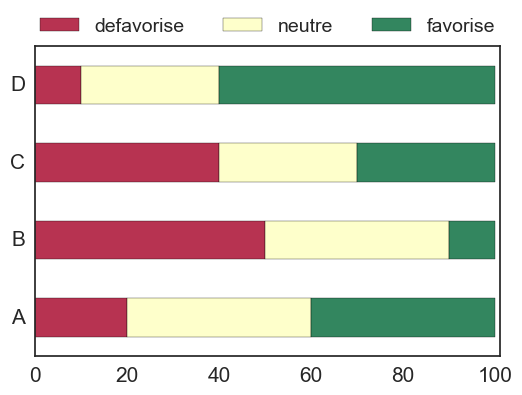

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_percent_t.plot(kind="barh", stacked=True, ax=ax, colormap="RdYlGn", alpha=.8, xlim=(0, 101))
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=False, fontsize=14)

Un peu plus de détails, la partie compliquée est l'ajout des annotations.

[0, 20.0, 60.0, 100.0]
[0, 50.0, 90.0, 100.0]
[0, 40.0, 70.0, 100.0]
[0, 10.0, 40.0, 100.0]


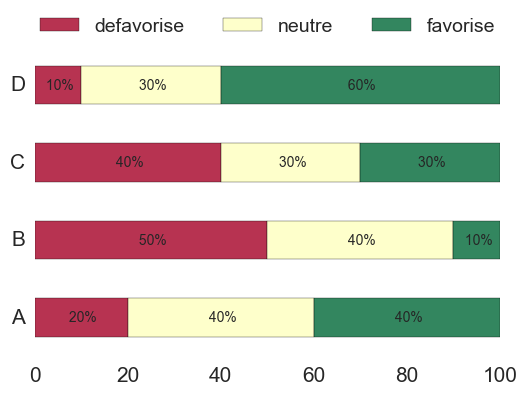

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_percent_t.plot(kind="barh", stacked=True, ax=ax, colormap="RdYlGn", alpha=.8)
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=False, fontsize=14)
ax.set_frame_on(False)

# add texts
y = 0
for index, row in df_percent_t.iterrows(): # boucle sur les lignes
    # on calcule les intervalles 
    xbounds = [0]
    for i in range(len(row)): # len(row) est le nombre d'éléments sur la ligne, 3 ici
        xbounds.append(xbounds[i] + row[i])
    print(xbounds)
    # ajout du texte au centre de chaque intervalle
    for i in range(3):
        x = (xbounds[i] + xbounds[i+1]) / 2
        ax.text(x, y, "%3.0f%%" % row[i], 
                verticalalignment="center",
                horizontalalignment="center")
    y += 1


Pour y voir plus clair sur le calcul des intervalles, voici un exemple :

In [16]:
l = [40, 50, 10]
x = [0]
for i in range(3):
    x.append(x[i] + l[i])
print(x)

[0, 40, 90, 100]
